In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from jepa.utils import set_seed
from jepa.dataset import load_cifar, load_mnist
from jepa.model.autoencoder import AutoEncoder, AutoencoderCriterion
from jepa.model.jepa import Jepa
from jepa.utils import sequential_from_string
from jepa.evaluation import train_classifier, build_dataset_of_latents
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

## Jepa

In [2]:
csv_path = "../dataframes/linear_jepa_cifar.csv"
df = pd.read_csv(csv_path)
df.head()

,Name,Created,Runtime,State,device/device,batch_size,test_size,train_size,model/type,model/activation,...,train/epoch,train/flatness_avg_diff,train/latent_l1norm,train/loss,train/weight_norm,val/denoising_avg_diff,val/epoch,val/flatness_avg_diff,val/latent_l1norm,val/loss
0,smart-sweep-150,2024-04-20T01:51:31.000Z,88,finished,cuda,64,4096,16384,Jepa,NaN,...,50,NaN,0.163857,0.003276,NaN,NaN,50,NaN,0.172956,0.004516
1,whole-sweep-149,2024-04-20T01:49:58.000Z,90,finished,cuda,64,4096,16384,Jepa,NaN,...,50,NaN,0.061119,0.001953,NaN,NaN,50,NaN,0.070309,0.003153
2,amber-sweep-148,2024-04-20T01:48:20.000Z,93,finished,cuda,64,4096,16384,Jepa,NaN,...,50,NaN,0.092054,0.002468,NaN,NaN,50,NaN,0.113451,0.003434
3,easy-sweep-147,2024-04-20T01:46:41.000Z,95,finished,cuda,64,4096,16384,Jepa,NaN,...,50,NaN,0.060832,0.003079,NaN,NaN,50,NaN,0.071301,0.004227
4,golden-sweep-146,2024-04-20T01:45:04.000Z,91,finished,cuda,64,4096,16384,Jepa,NaN,...,50,NaN,0.082574,0.001592,NaN,NaN,50,NaN,0.094391,0.002368


In [3]:
# group by the column model/encoder and average the numerical columns only
df = df.groupby("model/encoder").mean(numeric_only=True)
len(df)

30

In [4]:
relu, tanh = {}, {}
for architecture, metrics in df.iterrows():
    model = sequential_from_string(architecture)
    D = model[0].out_features
    d = relu if "relu" in architecture.lower() else tanh
    d[D] = metrics["classification/best_acc"]
relu = dict(sorted(relu.items()))
tanh = dict(sorted(tanh.items()))

In [7]:
sparsity_relu = {}
sparsity_tanh = {}
for architecture, metrics in df.iterrows():
    model = sequential_from_string(architecture)
    D = model[0].out_features
    d = sparsity_relu if "relu" in architecture.lower() else sparsity_tanh
    d[D] = metrics["val/latent_l1norm"]
sparsity_relu = dict(sorted(sparsity_relu.items()))
sparsity_tanh = dict(sorted(sparsity_tanh.items()))

In [10]:
dims = list(relu.keys())

## Raw data

In [55]:
root = "../data"
load_dataset = load_cifar
train_size = df["train_size"].iloc[0]
test_size = df["test_size"].iloc[0]
train_dataset, train_metadata = load_dataset(train=True, log_to_wandb=False, root=root, jepa=False)
test_dataset, test_metadata = load_dataset(train=False, log_to_wandb=False, root=root, jepa=False)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)  # be mindful of the batch size

Files already downloaded and verified
Files already downloaded and verified


In [60]:
input_dim = 3072
num_classes = 10
max_epochs = df["classification_epochs"].iloc[0].astype(int)
device = "cpu"
classifier = nn.Linear(input_dim, num_classes).to(device)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

accs = train_classifier(classifier, train_loader, test_loader, criterion=criterion,
                                   optimizer=optimizer, epochs=max_epochs, device=device)
raw = max(accs)
print(raw)

0.3696


## Random Projection

In [58]:
dims = list(relu.keys())
random = {}
for D in dims:
    encoder = nn.Linear(input_dim, D)
    train_latents_dataset = build_dataset_of_latents(encoder, train_loader, device)
    train_latents_dl = DataLoader(train_latents_dataset, batch_size=batch_size, shuffle=True)
    test_latents_dataset = build_dataset_of_latents(encoder, test_loader, device)
    test_latents_dl = DataLoader(test_latents_dataset, batch_size=batch_size, shuffle=False)
    classifier = nn.Linear(D, num_classes)
    optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3, weight_decay=1e-3)
    criterion = nn.CrossEntropyLoss()
    accs = train_classifier(classifier, train_latents_dl, test_latents_dl, criterion=criterion,
                            optimizer=optimizer, epochs=max_epochs, device=device)
    random[D] = max(accs)
    print(D, random[D])

10 0.245
20 0.2941
30 0.3172
50 0.3329
100 0.3752
200 0.3913
300 0.3976
400 0.4008
500 0.4058
750 0.4095
1000 0.4045
1500 0.4076
2000 0.4021
2500 0.3992
3072 0.3965


## Plot Accuracy

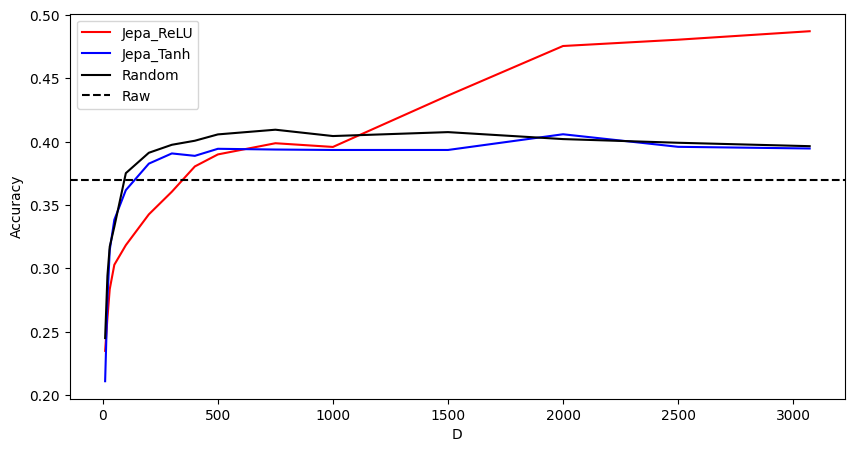

In [62]:
plt.figure(figsize=(10, 5))
plt.plot(dims, [relu[D] for D in dims], label="Jepa_ReLU", color="red")
plt.plot(dims, [tanh[D] for D in dims], label="Jepa_Tanh", color="blue")
plt.plot(dims, [random[D] for D in dims], label="Random", color="black")
plt.axhline(raw, color="black", linestyle="--", label="Raw")
plt.xlabel("D")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Plot Sparsity

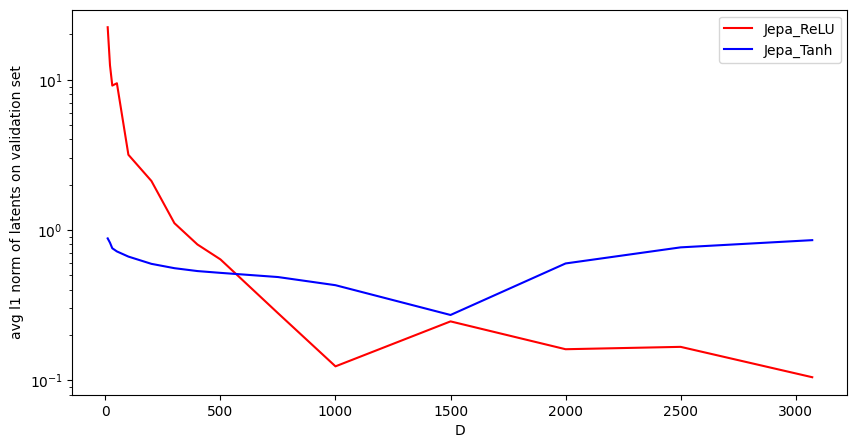

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(dims, [sparsity_relu[D] for D in dims], label="Jepa_ReLU", color="red")
plt.plot(dims, [sparsity_tanh[D] for D in dims], label="Jepa_Tanh", color="blue")
plt.xlabel("D")
plt.ylabel("avg l1 norm of latents on validation set")
plt.yscale("log")
plt.legend()
plt.show()